Le but de ce notebook est d'étudier les choix strategiques qu'un entraineur puisse faire lors de l'etablissement de sa feuille de match.

Il inclut les grands axes suivants: 

* 1) Choix d'une metrique pour evaluer la performance des equipes par saison: nombre de points moyen gagnés par match. Si le temps: on pourrait raffiner la metrique en prenant en compte l'equipe adverse, si le match est dispute a domicile ou a l'exterieur, et en prenant en compte le goal average.
* 2) Quels attributs d'équipe un entraineur devrait-il privilégier ? (Une defense aggressive ? Une attaque pleine de dribbleurs ? un jeu de construction collectif ?)
* 3) Quels attributs de joueur devrait-il privilégier pour chaque poste ?
* 4) Quelle formation d'équipe un entraineur devrait-il privilégier ?
* 5) Conclusion


Auteur: Louis Poitevin

Data source: Kaggle. https://www.kaggle.com/hugomathien/soccer

# Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sqlite3
from collections import Counter

# Import Data

In [2]:
# connecting to database and query
conn = sqlite3.connect('database.sqlite')

# sql query to get data
sql_match = """SELECT * FROM Match""" 
sql_team= """SELECT * FROM Team"""
sql_team_att="""SELECT * FROM Team_attributes"""
sql_player="""SELECT * FROM Player"""
sql_player_att="""SELECT * FROM Player_Attributes"""
sql_countries= """SELECT * FROM Country"""
sql_leagues="""SELECT * FROM League"""

# loading the data
match = pd.read_sql_query(sql_match, conn)
players= pd.read_sql_query(sql_player, conn)
players_att= pd.read_sql_query(sql_player_att, conn)
teams= pd.read_sql_query(sql_team, conn)
teams_att= pd.read_sql_query(sql_team_att, conn)
countries= pd.read_sql_query(sql_countries, conn)
leagues= pd.read_sql_query(sql_leagues, conn)

# Preprocessing

## Fonctions

In [3]:
#Creer deux nouvelles columns avec le nombre de points obtenus pour chaque equipe a l'issu d'un match
def victoire_points(df):

    #home wins
    df.loc[df['home_team_goal'] - df['away_team_goal'] > 0, 'points_home_team'] = 3
    #home draws
    df.loc[df['home_team_goal'] - df['away_team_goal'] == 0, 'points_home_team'] = 1
    #home loses
    df.loc[df['home_team_goal'] - df['away_team_goal'] < 0, 'points_home_team'] = 0
    #away wins
    df.loc[df['home_team_goal'] - df['away_team_goal'] < 0, 'points_away_team'] = 3
    #away draws
    df.loc[df['home_team_goal'] - df['away_team_goal'] == 0, 'points_away_team'] = 1
    #away loses
    df.loc[df['home_team_goal'] - df['away_team_goal'] > 0, 'points_away_team'] = 0

In [4]:
def map_position_to_label(position):
    
    #goal
    if position == (1,1):
        return 'goal'
    #defenseur lateral gauche
    elif ((1<=position[0]) & (position[0]<=3)) & ((1<=position[1]) & (position[1]<=4)):
        return 'lateral_gauche'
    #defenseur central
    elif ((4<=position[0]) & (position[0]<=7)) & ((1<=position[1]) & (position[1]<=4)):
        return 'defenseur_central'   
    #defenseur lateral droit
    elif ((8<=position[0]) & (position[0]<=11)) & ((1<=position[1]) & (position[1]<=4)):
        return 'lateral_droit'
     #milieu gauche 
    elif ((1<=position[0]) & (position[0]<=3)) & ((5<=position[1]) & (position[1]<=7)):
        return 'milieu_gauche'   
     #milieu defensif 
    elif ((4<=position[0]) & (position[0]<=7)) & ((5<=position[1]) & (position[1]<=7)):
        return 'milieu_defensif'  
     #milieu droit
    elif ((8<=position[0]) & (position[0]<=11)) & ((5<=position[1]) & (position[1]<=7)):
        return 'milieu_droit' 
     #milieu offensif
    elif ((4<=position[0]) & (position[0]<=7)) & ((8<=position[1]) & (position[1]<=9)):
        return 'milieu_offensif' 
     #ailier gauche
    elif ((1<=position[0]) & (position[0]<=3)) & ((8<=position[1]) & (position[1]<=11)):
        return 'ailier_gauche' 
     #ailier droit
    elif ((8<=position[0]) & (position[0]<=11)) & ((8<=position[1]) & (position[1]<=11)):
        return 'ailier_droit' 
     #attaquant
    elif ((4<=position[0]) & (position[0]<=7)) & ((10<=position[1]) & (position[1]<=11)):
        return 'attaquant' 

In [5]:
def mean_players_top_autres_flop(df_player_att, poste=None):
    
    if poste != None:
        df=df_player_att[df_player_att['poste']==poste]
    else:
        df=df_player_att.copy()
        
    #prendre joeurus:
    #merge avec top teams
    df_top_players=pd.merge(df_top_teams[['team_api_id', 'season']], df, on=['team_api_id', 'season'], how='inner')
    #merge avec reste teams
    df_autre_players=pd.merge(df_autre_teams[['team_api_id', 'season']], df, on=['team_api_id', 'season'], how='inner')
    # merge avec flop teams
    df_flop_players=pd.merge(df_flop_teams[['team_api_id', 'season']], df, on=['team_api_id', 'season'], how='inner')
    
    
    #moyenne des caracteristiques des joueurs top equipes
    df_top_players_mean=df_top_players[lst_players_att].mean()
    #moyenne des caracteristiques du reste des joueurs
    df_autre_players_mean=df_autre_players[lst_players_att].mean()
    #moyenne des caracteristiques des joueurs flop equipes
    df_flop_players_mean=df_flop_players[lst_players_att].mean()
    
    #creer deux df pour effectuerles comparaisons
    dict_players_top_vs_autres={'top_players': df_top_players_mean, 'reste': df_autre_players_mean}
    dict_players_top_vs_flop={'top_players': df_top_players_mean, 'flop_players': df_flop_players_mean}

    df_players_top_vs_autres=pd.DataFrame(data=dict_players_top_vs_autres)
    df_players_top_vs_flop=pd.DataFrame(data=dict_players_top_vs_flop)

    #ajoute une colonne avec la difference en pourcentage. I.e: de combien de pourcent est le top joueurs par rapport aux autres.
    df_players_top_vs_autres['delta_perc']=((df_players_top_vs_autres['top_players'] - df_players_top_vs_autres['reste'])/df_players_top_vs_autres['reste'])*100
    df_players_top_vs_flop['delta_perc']=((df_players_top_vs_flop['top_players'] - df_players_top_vs_flop['flop_players'])/df_players_top_vs_flop['flop_players'])*100

    #on tri les valeurs de la plus grande a la plus petite pour visualisations
    df_players_top_vs_autres=df_players_top_vs_autres.sort_values(by='delta_perc', ascending=False).reset_index()
    df_players_top_vs_flop=df_players_top_vs_flop.sort_values(by='delta_perc', ascending=False).reset_index()

    return df_players_top_vs_autres, df_players_top_vs_flop 

In [6]:
def visualisation_players_att(df_playersattr_compared, title):

    
    df_playersattr_compared = df_playersattr_compared.sort_values(by='delta_perc', ascending=True).reset_index()
    df_playersattr_compared['positive'] = df_playersattr_compared['delta_perc'] > 0
    
    data = df_playersattr_compared
    group_data = df_playersattr_compared['delta_perc']
    group_names = df_playersattr_compared['index']
    order = df_playersattr_compared.index.values
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(5, 10))
    ax.barh(order, group_data, color=df_playersattr_compared.positive.map({True: '#99CC99', False: '#F4874B'}))
    ax.set(xlim=[min(df_playersattr_compared['delta_perc'])-5, max(df_playersattr_compared['delta_perc'])+5])
    ax.set_yticklabels(labels=df_playersattr_compared['index'])
    ax.set_yticks(np.arange(0, 38, step=1))
    
    plt.xlabel('difference in percentage of top team players to '+title, size = 12)
    plt.ylabel('Player Attributes', size = 12)
    plt.title('Mean score of top team players compared to' +title, size = 12)
    plt.xticks(size = 8)
    plt.yticks(size = 8);
    

## Create Dataframes out of data

In [7]:
lst_col_players_home=['home_player_1',
 'home_player_2',
 'home_player_3',
 'home_player_4',
 'home_player_5',
 'home_player_6',
 'home_player_7',
 'home_player_8',
 'home_player_9',
 'home_player_10',
 'home_player_11']
lst_col_players_away=['away_player_1',
 'away_player_2',
 'away_player_3',
 'away_player_4',
 'away_player_5',
 'away_player_6',
 'away_player_7',
 'away_player_8',
 'away_player_9',
 'away_player_10',
 'away_player_11']
lst_col_X_home=['home_player_X1',
 'home_player_X2',
 'home_player_X3',
 'home_player_X4',
 'home_player_X5',
 'home_player_X6',
 'home_player_X7',
 'home_player_X8',
 'home_player_X9',
 'home_player_X10',
 'home_player_X11']
lst_col_X_away=['away_player_X1',
 'away_player_X2',
 'away_player_X3',
 'away_player_X4',
 'away_player_X5',
 'away_player_X6',
 'away_player_X7',
 'away_player_X8',
 'away_player_X9',
 'away_player_X10',
 'away_player_X11']
lst_col_Y_home=[ 'home_player_Y1',
 'home_player_Y2',
 'home_player_Y3',
 'home_player_Y4',
 'home_player_Y5',
 'home_player_Y6',
 'home_player_Y7',
 'home_player_Y8',
 'home_player_Y9',
 'home_player_Y10',
 'home_player_Y11']
lst_col_Y_away=['away_player_Y1',
 'away_player_Y2',
 'away_player_Y3',
 'away_player_Y4',
 'away_player_Y5',
 'away_player_Y6',
 'away_player_Y7',
 'away_player_Y8',
 'away_player_Y9',
 'away_player_Y10',
 'away_player_Y11']

### Position des joueurs de chaque equipes sur le terrain

In [8]:
#every row is a match, take out formation according to Y coordinates
home_formation = {}
away_formation = {}
for index,row in match.iterrows():
    home_player_y = list()
    away_player_y = list()
    #create two list to store Y coordinate for each team,and they should be empty when we start parse a new match
    
    for i in range(2,12):
        home_player_y.append(row['home_player_Y%d' % i])
        away_player_y.append(row['away_player_Y%d' % i])
    #put two teams's Y coordinates into list    
    
    c_home = Counter(home_player_y)
    c_away = Counter(away_player_y)
    #transform list to Counter objects
    formation_home = Counter(sorted(c_home.elements())).values()
    #sorted,for exsample: Y coordinate may be record with wrong, like "5,5,3,3,3,3,5,7,7,10", the correct formation should be 4321,
    #but if we don't serted it, we will get 3421
    #formation_home = OnlyNum(str(formation_home))
    #get only number, like '442', but it is still a string.
    formation_away = Counter(sorted(c_away.elements())).values()
    #formation_away = OnlyNum(str(formation_away))
    
    home_formation.update({row['match_api_id'] : formation_home})
    away_formation.update({row['match_api_id'] : formation_away})
    #update match id and formation to dict

In [9]:
match['home_formation'] = match['match_api_id'].map(home_formation)
match['away_formation'] = match['match_api_id'].map(away_formation)

Un Dataframe avec la formation des joueurs et les resultats du match

In [10]:
df_match_position = match[lst_col_X_home+lst_col_Y_home+lst_col_X_away+lst_col_Y_away+['home_team_api_id','home_team_goal','away_team_api_id','away_team_goal','season', 'league_id','home_formation','away_formation']]

In [11]:
for X, Y in zip(lst_col_X_home, lst_col_Y_home):
    
    player_number=X.split('player_X')[-1]
    
    df_match_position['home_position_player_'+player_number]=list(zip(df_match_position[X],df_match_position[Y]))
    
for X, Y in zip(lst_col_X_away, lst_col_Y_away):
    
    player_number=X.split('player_X')[-1]
    
    df_match_position['away_position_player_'+player_number]=list(zip(df_match_position[X],df_match_position[Y]))    
    

<ipython-input-11-123da9fc1c82>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_position['home_position_player_'+player_number]=list(zip(df_match_position[X],df_match_position[Y]))
<ipython-input-11-123da9fc1c82>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_match_position['away_position_player_'+player_number]=list(zip(df_match_position[X],df_match_position[Y]))


In [12]:
df_match_position=df_match_position.drop(lst_col_X_home+lst_col_Y_home+lst_col_X_away+lst_col_Y_away, axis=1)

In [13]:
df_match_position.tail()

,home_team_api_id,home_team_goal,away_team_api_id,away_team_goal,season,league_id,home_formation,away_formation,home_position_player_1,home_position_player_2,...,away_position_player_2,away_position_player_3,away_position_player_4,away_position_player_5,away_position_player_6,away_position_player_7,away_position_player_8,away_position_player_9,away_position_player_10,away_position_player_11
25974,10190,1,10191,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,"(2.0, 3.0)","(4.0, 3.0)","(6.0, 3.0)","(8.0, 3.0)","(4.0, 6.0)","(6.0, 6.0)","(3.0, 8.0)","(5.0, 8.0)","(7.0, 8.0)","(5.0, 11.0)"
25975,9824,1,10199,2,2015/2016,24558,"(3, 4, 1, 2)","(4, 3, 3)","(1.0, 1.0)","(3.0, 3.0)",...,"(2.0, 3.0)","(4.0, 3.0)","(6.0, 3.0)","(8.0, 3.0)","(3.0, 7.0)","(5.0, 7.0)","(7.0, 7.0)","(3.0, 10.0)","(5.0, 10.0)","(7.0, 10.0)"
25976,9956,2,10179,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,"(2.0, 3.0)","(4.0, 3.0)","(6.0, 3.0)","(8.0, 3.0)","(4.0, 6.0)","(6.0, 6.0)","(3.0, 8.0)","(5.0, 8.0)","(7.0, 8.0)","(5.0, 11.0)"
25977,7896,0,10243,0,2015/2016,24558,"(4, 3, 3)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,"(2.0, 3.0)","(4.0, 3.0)","(6.0, 3.0)","(8.0, 3.0)","(4.0, 6.0)","(6.0, 6.0)","(3.0, 8.0)","(5.0, 8.0)","(7.0, 8.0)","(5.0, 11.0)"
25978,10192,4,9931,3,2015/2016,24558,"(4, 4, 2)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,"(2.0, 3.0)","(4.0, 3.0)","(6.0, 3.0)","(8.0, 3.0)","(4.0, 6.0)","(6.0, 6.0)","(3.0, 8.0)","(5.0, 8.0)","(7.0, 8.0)","(5.0, 11.0)"


In [14]:
for home_player, away_player in zip(lst_col_players_home, lst_col_players_away):
    
    player_number=home_player.split('home_player_')[-1]
    
    
    df_match_position['poste_home_player_'+player_number]=df_match_position['home_position_player_'+player_number].apply(map_position_to_label)
    df_match_position['poste_away_player_'+player_number]=df_match_position['away_position_player_'+player_number].apply(map_position_to_label)


In [15]:
df_match_position.columns.tolist()

['home_team_api_id',
 'home_team_goal',
 'away_team_api_id',
 'away_team_goal',
 'season',
 'league_id',
 'home_formation',
 'away_formation',
 'home_position_player_1',
 'home_position_player_2',
 'home_position_player_3',
 'home_position_player_4',
 'home_position_player_5',
 'home_position_player_6',
 'home_position_player_7',
 'home_position_player_8',
 'home_position_player_9',
 'home_position_player_10',
 'home_position_player_11',
 'away_position_player_1',
 'away_position_player_2',
 'away_position_player_3',
 'away_position_player_4',
 'away_position_player_5',
 'away_position_player_6',
 'away_position_player_7',
 'away_position_player_8',
 'away_position_player_9',
 'away_position_player_10',
 'away_position_player_11',
 'poste_home_player_1',
 'poste_away_player_1',
 'poste_home_player_2',
 'poste_away_player_2',
 'poste_home_player_3',
 'poste_away_player_3',
 'poste_home_player_4',
 'poste_away_player_4',
 'poste_home_player_5',
 'poste_away_player_5',
 'poste_home_player

In [16]:
df_match_position.tail()

,home_team_api_id,home_team_goal,away_team_api_id,away_team_goal,season,league_id,home_formation,away_formation,home_position_player_1,home_position_player_2,...,poste_home_player_7,poste_away_player_7,poste_home_player_8,poste_away_player_8,poste_home_player_9,poste_away_player_9,poste_home_player_10,poste_away_player_10,poste_home_player_11,poste_away_player_11
25974,10190,1,10191,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,milieu_defensif,ailier_gauche,ailier_gauche,milieu_offensif,milieu_offensif,milieu_offensif,milieu_offensif,attaquant,attaquant
25975,9824,1,10199,2,2015/2016,24558,"(3, 4, 1, 2)","(4, 3, 3)","(1.0, 1.0)","(3.0, 3.0)",...,milieu_defensif,milieu_defensif,milieu_droit,milieu_defensif,milieu_offensif,ailier_gauche,attaquant,attaquant,attaquant,attaquant
25976,9956,2,10179,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,milieu_defensif,ailier_gauche,ailier_gauche,milieu_offensif,milieu_offensif,milieu_offensif,milieu_offensif,attaquant,attaquant
25977,7896,0,10243,0,2015/2016,24558,"(4, 3, 3)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,milieu_defensif,milieu_defensif,ailier_gauche,ailier_gauche,milieu_offensif,attaquant,milieu_offensif,attaquant,attaquant
25978,10192,4,9931,3,2015/2016,24558,"(4, 4, 2)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,milieu_defensif,milieu_defensif,ailier_gauche,milieu_droit,milieu_offensif,attaquant,milieu_offensif,attaquant,attaquant


### Liste des joueurs pour chaque équipes dans chaque saison

Un Dataframe avec, pour chaque saison, tout les joueurs avec l'equipe correspondante

In [17]:
#joueurs des equipes a homes
df_player_home=pd.concat([match.loc[:,match.columns.str.contains('home_player')], match[['home_team_api_id', 'season']]], axis=1)

#pivot pour tout les joueurs et leurs positions
pivot_player_home=pd.melt(df_player_home[['home_team_api_id', 'season']+lst_col_players_home], id_vars=['home_team_api_id', 'season'], var_name=['players'], value_name='player_api_id').dropna()
pivot_X_home=pd.melt(df_player_home[['home_team_api_id', 'season']+lst_col_X_home], id_vars=['home_team_api_id', 'season'], var_name=['players_X'], value_name='position_X').dropna()
pivot_Y_home=pd.melt(df_player_home[['home_team_api_id', 'season']+lst_col_Y_home], id_vars=['home_team_api_id', 'season'], var_name=['players_Y'], value_name='position_Y').dropna()

#on concatenate les resultats
df_player_home=pd.concat([pivot_player_home,pivot_X_home,pivot_Y_home], axis=1).dropna()

#on enleve les columns dupliquées et inutiles
df_player_home= df_player_home.loc[:,~df_player_home.columns.duplicated()]
df_player_home=df_player_home.drop(['players', 'players_X', 'players_Y'], axis=1)

#enleve duplicats des joueurs, equipes et saisons, en prenant la position la plus frequemment adoptee pour le joueur en question
df_player_home=df_player_home.groupby(['player_api_id','home_team_api_id','season'])['position_X','position_Y'].agg(lambda x : x.mode()[0]).reset_index()
df_player_home.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)

<ipython-input-17-275b1d8f7017>:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_player_home=df_player_home.groupby(['player_api_id','home_team_api_id','season'])['position_X','position_Y'].agg(lambda x : x.mode()[0]).reset_index()


In [18]:
#joueurs des equipes a exterieur
df_player_away=pd.concat([match.loc[:,match.columns.str.contains('away_player')], match[['away_team_api_id', 'season']]], axis=1)

#pivot pour tout les joueurs et leurs positions
pivot_player_away=pd.melt(df_player_away[['away_team_api_id', 'season']+lst_col_players_away], id_vars=['away_team_api_id', 'season'], var_name=['players'], value_name='player_api_id').dropna()
pivot_X_away=pd.melt(df_player_away[['away_team_api_id', 'season']+lst_col_X_away], id_vars=['away_team_api_id', 'season'], var_name=['players_X'], value_name='position_X').dropna()
pivot_Y_away=pd.melt(df_player_away[['away_team_api_id', 'season']+lst_col_Y_away], id_vars=['away_team_api_id', 'season'], var_name=['players_Y'], value_name='position_Y').dropna()

#on concatenate les resultats
df_player_away=pd.concat([pivot_player_away,pivot_X_away,pivot_Y_away], axis=1).dropna()

#on enleve les columns dupliquées et inutiles
df_player_away= df_player_away.loc[:,~df_player_away.columns.duplicated()]
df_player_away=df_player_away.drop(['players', 'players_X', 'players_Y'], axis=1)

#enleve duplicats des joueurs, equipes et saisons, en prenant la position la plus frequemment adoptee pour le joueur en question
df_player_away=df_player_away.groupby(['player_api_id','away_team_api_id','season'])['position_X','position_Y'].agg(lambda x : x.mode()[0]).reset_index()
df_player_away.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

<ipython-input-18-d9fbbdb4648a>:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_player_away=df_player_away.groupby(['player_api_id','away_team_api_id','season'])['position_X','position_Y'].agg(lambda x : x.mode()[0]).reset_index()


In [19]:
#merge les deux dataframes home and away
df_player=df_player_home.append(df_player_away, ignore_index=True)
df_player=df_player.drop_duplicates(subset=['team_api_id', 'season', 'player_api_id', 'position_X','position_Y'], keep='first')

In [20]:
df_player['position']=list(zip(df_player['position_X'],df_player['position_Y']))
df_player=df_player.drop(['position_X', 'position_Y'], axis=1)


In [21]:
df_player['poste']=df_player['position'].apply(map_position_to_label)

In [22]:
df_player

,player_api_id,team_api_id,season,position,poste
0,2625.0,8569.0,2014/2015,"(4.0, 6.0)",milieu_defensif
1,2752.0,7878.0,2011/2012,"(6.0, 3.0)",defenseur_central
2,2752.0,7878.0,2012/2013,"(6.0, 3.0)",defenseur_central
3,2752.0,7878.0,2013/2014,"(4.0, 3.0)",defenseur_central
4,2752.0,7878.0,2014/2015,"(6.0, 3.0)",defenseur_central
...,...,...,...,...,...
64504,725718.0,10217.0,2015/2016,"(7.0, 10.0)",attaquant
64506,728414.0,9791.0,2015/2016,"(6.0, 3.0)",defenseur_central
64508,743720.0,9931.0,2015/2016,"(6.0, 6.0)",milieu_defensif
64509,746419.0,6403.0,2015/2016,"(2.0, 3.0)",lateral_gauche


## Data Cleaning

### Teams

#### NaN

In [23]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


-Il y a 299 equipes recensees, 11 ne sont pas repertories par la fifa, mais a priori nous n'utilisons pas cet attribut

In [24]:
teams_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

In [25]:
teams_att[teams_att['buildUpPlayDribbling'].isna()]['buildUpPlayDribblingClass'].value_counts()

Little    969
Name: buildUpPlayDribblingClass, dtype: int64

-BuildUpPlayDribbling n'a que 489 valeurs. Mais "Classe" a toutes ses valeurs. En regardant, les valeurs NaN des BuildUpPlayBuidling correspondent toutes a la classe "Little", ce qui fait sens. 

In [26]:
teams_att[teams_att['buildUpPlayDribblingClass']=='Little']['buildUpPlayDribbling'].value_counts()

32.0    12
33.0     6
31.0     4
29.0     4
28.0     3
24.0     2
30.0     2
27.0     1
26.0     1
Name: buildUpPlayDribbling, dtype: int64

en regardant ces valeurs, on voit que toutes valeurs correspondantes a la classe "Little" sont autour de 32 avec tres peu de variance. On remplace les NaN par la valeur 32.

In [27]:
teams_att['buildUpPlayDribbling'].fillna(32, inplace=True)

#### Duplicatas

In [28]:
teams[teams.duplicated(['team_api_id'])]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name


teams n'a pas de duplicata.

In [29]:
teams_att[teams_att.duplicated(['team_api_id','date'])]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
860,861,111560,9996,2015-09-10 00:00:00,50,Balanced,50.0,Normal,50,Mixed,...,50,Normal,Organised,45,Medium,45,Press,50,Normal,Cover


In [30]:
#ce duplicat n'est pas normal il faut l'enlever
teams_att.drop_duplicates(subset=['team_api_id', 'date'], inplace=True)

#### Concordance entre teams et teams attribut

In [31]:
pd.merge(teams, teams_att, on='team_api_id')['team_api_id'].nunique()

288

288 teams sur 299 sont representees dans teams_att

In [32]:
pd.to_datetime(teams_att['date']).dt.year.value_counts()

2015    244
2014    244
2011    244
2013    242
2012    242
2010    241
Name: date, dtype: int64

On voit qu'il va manquer des saisons pour certains clubs

### Match 

#### Duplicatas

In [33]:
match[match.duplicated('match_api_id')]

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_formation,away_formation


### Players Position Match

On rajoute deux columns avec les points gagnes lors du match (une pour l'exterieur et une pour domicile)

In [34]:
df_match_position.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 52 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   home_team_api_id         25979 non-null  int64 
 1   home_team_goal           25979 non-null  int64 
 2   away_team_api_id         25979 non-null  int64 
 3   away_team_goal           25979 non-null  int64 
 4   season                   25979 non-null  object
 5   league_id                25979 non-null  int64 
 6   home_formation           25979 non-null  object
 7   away_formation           25979 non-null  object
 8   home_position_player_1   25979 non-null  object
 9   home_position_player_2   25979 non-null  object
 10  home_position_player_3   25979 non-null  object
 11  home_position_player_4   25979 non-null  object
 12  home_position_player_5   25979 non-null  object
 13  home_position_player_6   25979 non-null  object
 14  home_position_player_7   25979 non-nul

In [35]:
victoire_points(df_match_position)

In [36]:
df_match_position.tail()

,home_team_api_id,home_team_goal,away_team_api_id,away_team_goal,season,league_id,home_formation,away_formation,home_position_player_1,home_position_player_2,...,poste_home_player_8,poste_away_player_8,poste_home_player_9,poste_away_player_9,poste_home_player_10,poste_away_player_10,poste_home_player_11,poste_away_player_11,points_home_team,points_away_team
25974,10190,1,10191,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,ailier_gauche,ailier_gauche,milieu_offensif,milieu_offensif,milieu_offensif,milieu_offensif,attaquant,attaquant,3.0,0.0
25975,9824,1,10199,2,2015/2016,24558,"(3, 4, 1, 2)","(4, 3, 3)","(1.0, 1.0)","(3.0, 3.0)",...,milieu_droit,milieu_defensif,milieu_offensif,ailier_gauche,attaquant,attaquant,attaquant,attaquant,0.0,3.0
25976,9956,2,10179,0,2015/2016,24558,"(4, 2, 3, 1)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,ailier_gauche,ailier_gauche,milieu_offensif,milieu_offensif,milieu_offensif,milieu_offensif,attaquant,attaquant,3.0,0.0
25977,7896,0,10243,0,2015/2016,24558,"(4, 3, 3)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,ailier_gauche,ailier_gauche,milieu_offensif,attaquant,milieu_offensif,attaquant,attaquant,1.0,1.0
25978,10192,4,9931,3,2015/2016,24558,"(4, 4, 2)","(4, 2, 3, 1)","(1.0, 1.0)","(2.0, 3.0)",...,milieu_defensif,ailier_gauche,milieu_droit,milieu_offensif,attaquant,milieu_offensif,attaquant,attaquant,3.0,0.0


#enlever Nan
df_match_position.dropna(inplace=True)
df_match_position.reset_index(inplace=True, drop=True)

### Players

#### NAN

In [37]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


Pas de NaN

In [38]:
players_att.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

Il y a quelques NaN

#### Duplicatas

In [39]:
players[players.duplicated(['player_api_id'])]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight


Pas de Duplicatas

In [40]:
players_att[players_att.duplicated(['player_api_id','date'])].value_counts()

Series([], dtype: int64)

In [41]:
#On voit qu'il y a des duplicatas, on doit s'en débarasser. En plus les autres attributs correspondants sont des NaN
players_att.drop_duplicates(subset=['player_api_id', 'date'], inplace=True)

#### Concordance players et players_att

In [42]:
pd.merge(players, players_att, on='player_api_id')['player_api_id'].nunique()

11060

# 1) Classement des équipes par performances 

## Choix d'une métrique pour noter la performance d'une équipe

Le choix naturel pour évaluer une équipe d'une certaine saison, **est de comptabiliser le nombre de points moyens gagnés par match**

On pourrait affiner la métrique:

- En pondérant le nombre de points en fonction de l'équipe affrontée et/ou de l'équipe en elle même. On pourrait utiliser les cotes par exemple. Une victoire contre une top equipe vaut plus que contre une low equipe.
- En pondérant avec le goal average (Buts marques vs but pris)
- En pondérant avec victoire domicile et extérieur


## Le classement

### Sommes des points gagnes par equipes par saison

In [43]:
#a domicile
df_match_points_home=df_match_position.groupby(['home_team_api_id', 'season', 'league_id'])['points_home_team'].agg(['sum', 'count']).reset_index()

# a l'exterieur
df_match_points_away=df_match_position.groupby(['away_team_api_id', 'season','league_id'])['points_away_team'].agg(['sum', 'count']).reset_index()

In [44]:
#rename colones
df_match_points_home.columns=['team_api_id','season','league_id', 'points', 'nombre_de_matchs']
df_match_points_away.columns=['team_api_id','season', 'league_id','points', 'nombre_de_matchs']

In [45]:
#concat les deux dataframes
df_match_points=pd.concat([df_match_points_home, df_match_points_away])

In [46]:
#group matchs and points par equipe et saison
df_match_points=df_match_points.groupby(['team_api_id', 'season', 'league_id'])['points', 'nombre_de_matchs'].sum().reset_index()

<ipython-input-46-75139f33d868>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_match_points=df_match_points.groupby(['team_api_id', 'season', 'league_id'])['points', 'nombre_de_matchs'].sum().reset_index()


In [47]:
# ajoute une colonne avec moyenne des points par matchs
df_match_points['points_par_match']=df_match_points['points']/df_match_points['nombre_de_matchs']

In [48]:
#ajoute columns avec nom des equipes
df_match_points=pd.merge(teams[['team_api_id','team_long_name']],df_match_points, how='right', on='team_api_id') 

In [49]:
#on classe par ordre decroissant
df_classement=df_match_points.sort_values(by='points_par_match', ascending=False)
df_classement.head()

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match
807,9773,FC Porto,2010/2011,17642,84.0,30,2.800000
1057,9885,Juventus,2013/2014,10257,102.0,38,2.684211
894,9823,FC Bayern Munich,2012/2013,7809,91.0,34,2.676471
895,9823,FC Bayern Munich,2013/2014,7809,90.0,34,2.647059
607,8633,Real Madrid CF,2011/2012,21518,100.0,38,2.631579


In [50]:
df_classement['nombre_de_matchs'].value_counts()

38    715
34    354
30    304
36     78
28     15
37      6
35      4
6       4
18      1
Name: nombre_de_matchs, dtype: int64

On peut peut etre filtrer ce df avec les equipes qui ont fait au moins 28 matchs

In [51]:
df_classement=df_classement[df_classement['nombre_de_matchs']>27].reset_index(drop=True)
df_classement

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match
0,9773,FC Porto,2010/2011,17642,84.0,30,2.800000
1,9885,Juventus,2013/2014,10257,102.0,38,2.684211
2,9823,FC Bayern Munich,2012/2013,7809,91.0,34,2.676471
3,9823,FC Bayern Munich,2013/2014,7809,90.0,34,2.647059
4,8633,Real Madrid CF,2011/2012,21518,100.0,38,2.631579
...,...,...,...,...,...,...,...
1471,10242,ES Troyes AC,2015/2016,4769,18.0,38,0.473684
1472,9984,KSV Cercle Brugge,2012/2013,1,14.0,30,0.466667
1473,10252,Aston Villa,2015/2016,1729,17.0,38,0.447368
1474,10219,RKC Waalwijk,2009/2010,13274,15.0,34,0.441176


Peut être devrions nous restreindre le df a quelques top championnats

df_classement_restr=df_classement[df_classement['league_id'].isin([1729, 4769, 7809, 10257,17642,21518])].reset_index(drop=True)

leagues_restr=leagues[leagues['id'].isin([1729, 4769, 7809, 10257,17642,21518])]
leagues_restr

df_classement_restr['league_id']=df_classement_restr[['league_id']].merge(leagues_restr, how='left', left_on='league_id', right_on='id')['name']

df_classement_restr

# 2) Quels attributs d'une équipe un selectioneur devrait privilégier ? 

## Attributs pour chaque equipe

On peut pour chaque equipe, on rajoute les attributs correspondants.

In [52]:
#rajoute deux colonnes debut_saison et fin_saison
df_classement['debut_saison']=df_classement['season'].str[:4] + '-07-01'
df_classement['fin_saison']=df_classement['season'].str[5:] + '-06-30'

In [53]:
#merge avec les attributs de teams.
df_classement=pd.merge(df_classement,teams_att, on='team_api_id', how='outer')


In [54]:
#On garde que les lignes ou les dates de team_att correpsondent avec les saisons
df_classement=df_classement[df_classement['date'].between(df_classement['debut_saison'], df_classement['fin_saison'])].reset_index(drop=True)

On voit que des equipes ont ete perdues. Ceci est dût a l'absence de donnees dans le dataframe tea_att avec une date correspondant aux saisons

In [55]:
df_classement=df_classement.sort_values(by='points_par_match', ascending=False)

In [56]:
df_classement.head()

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match,debut_saison,fin_saison,id,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9773,FC Porto,2010/2011,17642,84.0,30,2.800000,2010-07-01,2011-06-30,434.0,...,65.0,Normal,Free Form,55.0,Medium,43.0,Press,65.0,Normal,Cover
6,9885,Juventus,2013/2014,10257,102.0,38,2.684211,2013-07-01,2014-06-30,628.0,...,72.0,Lots,Free Form,66.0,Medium,67.0,Double,36.0,Normal,Cover
12,9823,FC Bayern Munich,2013/2014,7809,90.0,34,2.647059,2013-07-01,2014-06-30,146.0,...,39.0,Normal,Organised,52.0,Medium,54.0,Press,52.0,Normal,Cover
18,8633,Real Madrid CF,2011/2012,21518,100.0,38,2.631579,2011-07-01,2012-06-30,1051.0,...,73.0,Lots,Free Form,49.0,Medium,60.0,Press,68.0,Wide,Cover
30,9925,Celtic,2013/2014,19694,99.0,38,2.605263,2013-07-01,2014-06-30,292.0,...,60.0,Normal,Free Form,55.0,Medium,51.0,Press,60.0,Normal,Cover


## Top Equipes vs le reste

On split le dataframe en deux, d'un cote les equipes les plus efficaces, et de l'autre le reste.

On regarde la distribution des equipes:

In [57]:
df_classement['points_par_match'].describe(percentiles=[0.1,0.25,0.5,0.75])

count    1064.000000
mean        1.383453
std         0.437212
min         0.441176
10%         0.884314
25%         1.088235
50%         1.289474
75%         1.632018
max         2.800000
Name: points_par_match, dtype: float64

On s'interesse a definit les top teams performante. On prendra par exemple les 10% meilleures

In [58]:
percent=0.9
top_teams_quantile=df_classement['points_par_match'].quantile(percent)

In [59]:
df_top_teams=df_classement[df_classement['points_par_match']>top_teams_quantile].reset_index(drop=True)

In [60]:
df_top_teams.head(10)

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match,debut_saison,fin_saison,id,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9773,FC Porto,2010/2011,17642,84.0,30,2.800000,2010-07-01,2011-06-30,434.0,...,65.0,Normal,Free Form,55.0,Medium,43.0,Press,65.0,Normal,Cover
1,9885,Juventus,2013/2014,10257,102.0,38,2.684211,2013-07-01,2014-06-30,628.0,...,72.0,Lots,Free Form,66.0,Medium,67.0,Double,36.0,Normal,Cover
2,9823,FC Bayern Munich,2013/2014,7809,90.0,34,2.647059,2013-07-01,2014-06-30,146.0,...,39.0,Normal,Organised,52.0,Medium,54.0,Press,52.0,Normal,Cover
3,8633,Real Madrid CF,2011/2012,21518,100.0,38,2.631579,2011-07-01,2012-06-30,1051.0,...,73.0,Lots,Free Form,49.0,Medium,60.0,Press,68.0,Wide,Cover
4,9925,Celtic,2013/2014,19694,99.0,38,2.605263,2013-07-01,2014-06-30,292.0,...,60.0,Normal,Free Form,55.0,Medium,51.0,Press,60.0,Normal,Cover
5,8634,FC Barcelona,2009/2010,21518,99.0,38,2.605263,2009-07-01,2010-06-30,119.0,...,70.0,Lots,Free Form,70.0,High,30.0,Contain,70.0,Wide,Offside Trap
6,9772,SL Benfica,2015/2016,17642,88.0,34,2.588235,2015-07-01,2016-06-30,166.0,...,54.0,Normal,Organised,60.0,Medium,57.0,Press,54.0,Normal,Cover
7,8640,PSV,2014/2015,13274,88.0,34,2.588235,2014-07-01,2015-06-30,1012.0,...,55.0,Normal,Organised,50.0,Medium,62.0,Press,55.0,Normal,Cover
8,9823,FC Bayern Munich,2015/2016,7809,88.0,34,2.588235,2015-07-01,2016-06-30,148.0,...,22.0,Little,Free Form,72.0,High,53.0,Press,59.0,Normal,Cover
9,9772,SL Benfica,2009/2010,17642,76.0,30,2.533333,2009-07-01,2010-06-30,161.0,...,65.0,Normal,Free Form,30.0,Deep,30.0,Contain,30.0,Narrow,Offside Trap


In [61]:
df_autre_teams=df_classement[df_classement['points_par_match']<=top_teams_quantile].reset_index(drop=True)

In [62]:
df_autre_teams.head(10)

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match,debut_saison,fin_saison,id,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,8342,Club Brugge KV,2011/2012,1,61.0,30,2.033333,2011-07-01,2012-06-30,321.0,...,47.0,Normal,Organised,60.0,Medium,50.0,Press,52.0,Normal,Cover
1,8342,Club Brugge KV,2014/2015,1,61.0,30,2.033333,2014-07-01,2015-06-30,323.0,...,47.0,Normal,Organised,51.0,Medium,50.0,Press,57.0,Normal,Cover
2,9773,FC Porto,2013/2014,17642,61.0,30,2.033333,2013-07-01,2014-06-30,436.0,...,68.0,Lots,Organised,58.0,Medium,60.0,Press,57.0,Normal,Cover
3,8640,PSV,2011/2012,13274,69.0,34,2.029412,2011-07-01,2012-06-30,1010.0,...,48.0,Normal,Organised,43.0,Medium,30.0,Contain,48.0,Normal,Cover
4,8640,PSV,2010/2011,13274,69.0,34,2.029412,2010-07-01,2011-06-30,1009.0,...,68.0,Lots,Free Form,57.0,Medium,37.0,Press,64.0,Normal,Offside Trap
5,8721,VfL Wolfsburg,2014/2015,7809,69.0,34,2.029412,2014-07-01,2015-06-30,1419.0,...,54.0,Normal,Organised,59.0,Medium,48.0,Press,47.0,Normal,Cover
6,9931,FC Basel,2010/2011,24558,73.0,36,2.027778,2010-07-01,2011-06-30,132.0,...,49.0,Normal,Organised,38.0,Medium,53.0,Press,55.0,Normal,Cover
7,10267,Valencia CF,2014/2015,21518,77.0,38,2.026316,2014-07-01,2015-06-30,1312.0,...,55.0,Normal,Organised,51.0,Medium,38.0,Press,59.0,Normal,Cover
8,10243,FC Zürich,2010/2011,24558,72.0,36,2.000000,2010-07-01,2011-06-30,447.0,...,55.0,Normal,Organised,54.0,Medium,49.0,Press,60.0,Normal,Cover
9,8639,LOSC Lille,2010/2011,4769,76.0,38,2.000000,2010-07-01,2011-06-30,738.0,...,50.0,Normal,Organised,55.0,Medium,55.0,Press,35.0,Normal,Cover


## Visualisation

On choisit d'abord les attributs à plotter. On va plotter que les variables continue pour comparer.

In [63]:
attributs_equipes=['buildUpPlaySpeed',
 'buildUpPlayDribbling',
 'buildUpPlayPassing',
 'chanceCreationPassing',
 'chanceCreationCrossing',
 'chanceCreationShooting',
 'defencePressure',
 'defenceAggression',
 'defenceTeamWidth']

Pour chaque attribut, on prend la moyenne

In [64]:
df_top_teams_mean=df_top_teams[attributs_equipes].mean()
df_autre_teams_mean=df_autre_teams[attributs_equipes].mean()

In [65]:
df_top_teams_mean

buildUpPlaySpeed          51.386792
buildUpPlayDribbling      36.962264
buildUpPlayPassing        42.933962
chanceCreationPassing     55.198113
chanceCreationCrossing    54.603774
chanceCreationShooting    57.500000
defencePressure           52.056604
defenceAggression         52.198113
defenceTeamWidth          54.198113
dtype: float64

On creer la figure.

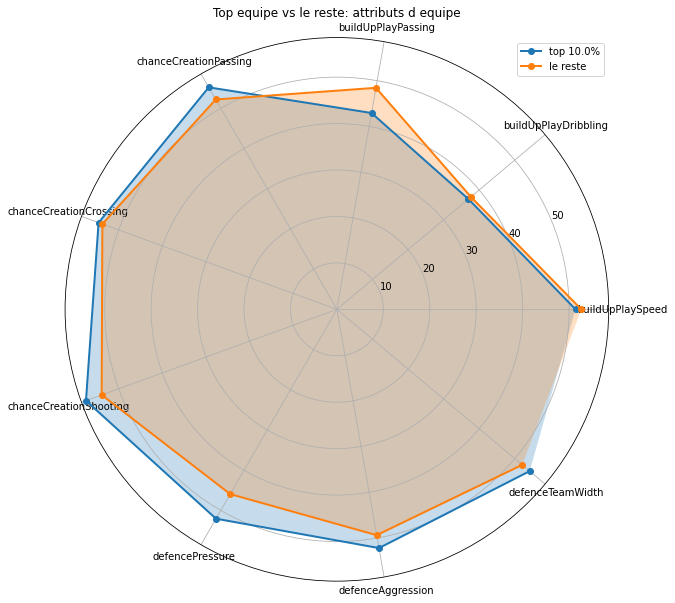

In [66]:
stats_top=df_top_teams_mean.values
stats_autre=df_autre_teams_mean.values

angles=np.linspace(0, 2*np.pi, len(attributs_equipes), endpoint=False)


fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats_top, 'o-', linewidth=2, label='top '+ str(100-percent*100)+'%')
ax.fill(angles, stats_top, alpha=0.25)
ax.plot(angles, stats_autre, 'o-', linewidth=2, label='le reste')
ax.fill(angles, stats_autre, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels=attributs_equipes)
ax.set_title('Top equipe vs le reste: attributs d equipe')
ax.grid(True)
ax.legend();

### Interpretation:

- Les attributs defensifs dans leur ensemble sont correles avec la bonne performance des equipes. En particulier, la pression des defenseurs sur les attaquants. On peut donc penser qu'un entraineur devrait non seulement privilegier le secteur defensif, mais surtout recruter des joueurs capable d'agressivite et de pressuriser les attaquants adverse avec un marquage solide. 
- La capacite d'une equipe a se creer des occasions est aussi superieur pour les top equipes. On voit ici que la correlation entre les equipes qui ont des joueurs qui se mettent en situation de tir, ou delivrent de passes decisives et les bonnes performances est plus grande. Un entraineur devrait donc surement aussi etre attentif d'avoir des joueurs creatifs, capable de tirer de loin par exemple, ou de delivrer des bonnes passes offensifs au bon moments.
- Etonnament, le reste des equipes a en moyenne une meilleure faculté a creer un jeu collectif de passes ou avoir des bon dribbleurs. On peut donc penser qu'un entraineur ne privilegiera pas une equipe capable de creer du beau football collectif dans la construction, ni d'avoir des dribbleurs de talents.

Etant moi même passioné de football et en discutant de ça, je trouve que ces resultats sont plein de sens. En effet, on se rappellera de l'italie championne grace à son systeme de defense musclé. De plus, c'est souvent une tactique payante pour les "petites equipes" de se reposer sur sa defense, tout en esperant marquer un but en contre attaque ou lors d'un coup de pied arrêté (Grece championnat d'europe en 2004). 
COmme dit le dicton: "posseder n'est pas gagné", avoir un beau jeu de passe est souvent spectaculaire, mais de mon point de vue moins efficace que des passes longues au bon moment ou des centres appliquées.

Nous pouvons faire la même analyse en prenant cette fois, les meilleurs et les moins bons. On espere voir la même tendance mais amplifié. On peut prendre les 10% moins bon par exemple.

In [67]:
flop_teams_quantile=df_classement['points_par_match'].quantile(1-percent)
df_flop_teams=df_classement[df_classement['points_par_match']<flop_teams_quantile].reset_index(drop=True)

In [68]:
df_flop_teams.head(10)

,team_api_id,team_long_name,season,league_id,points,nombre_de_matchs,points_par_match,debut_saison,fin_saison,id,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,8722,1. FC Köln,2011/2012,7809,30.0,34,0.882353,2011-07-01,2012-06-30,422.0,...,57.0,Normal,Organised,43.0,Medium,55.0,Press,67.0,Wide,Cover
1,10217,ADO Den Haag,2009/2010,13274,30.0,34,0.882353,2009-07-01,2010-06-30,28.0,...,65.0,Normal,Organised,30.0,Deep,30.0,Contain,30.0,Narrow,Cover
2,7730,FC Lausanne-Sports,2011/2012,24558,30.0,34,0.882353,2011-07-01,2012-06-30,673.0,...,48.0,Normal,Organised,43.0,Medium,43.0,Press,55.0,Normal,Cover
3,10238,Vitória Setúbal,2015/2016,17642,30.0,34,0.882353,2015-07-01,2016-06-30,1359.0,...,52.0,Normal,Organised,37.0,Medium,37.0,Press,58.0,Normal,Cover
4,8464,N.E.C.,2013/2014,13274,30.0,34,0.882353,2013-07-01,2014-06-30,891.0,...,57.0,Normal,Organised,45.0,Medium,48.0,Press,53.0,Normal,Cover
5,10218,Excelsior,2015/2016,13274,30.0,34,0.882353,2015-07-01,2016-06-30,418.0,...,43.0,Normal,Organised,29.0,Deep,41.0,Press,36.0,Normal,Cover
6,8191,Burnley,2014/2015,1729,33.0,38,0.868421,2014-07-01,2015-06-30,253.0,...,58.0,Normal,Organised,54.0,Medium,57.0,Press,58.0,Normal,Cover
7,8654,West Ham United,2010/2011,1729,33.0,38,0.868421,2010-07-01,2011-06-30,1386.0,...,45.0,Normal,Organised,45.0,Medium,45.0,Press,50.0,Normal,Cover
8,10251,Hibernian,2011/2012,19694,33.0,38,0.868421,2011-07-01,2012-06-30,588.0,...,44.0,Normal,Organised,42.0,Medium,40.0,Press,40.0,Normal,Cover
9,8597,Kilmarnock,2009/2010,19694,33.0,38,0.868421,2009-07-01,2010-06-30,642.0,...,65.0,Normal,Organised,60.0,Medium,70.0,Double,70.0,Wide,Cover


In [69]:
df_flop_teams_mean=df_flop_teams[attributs_equipes].mean()

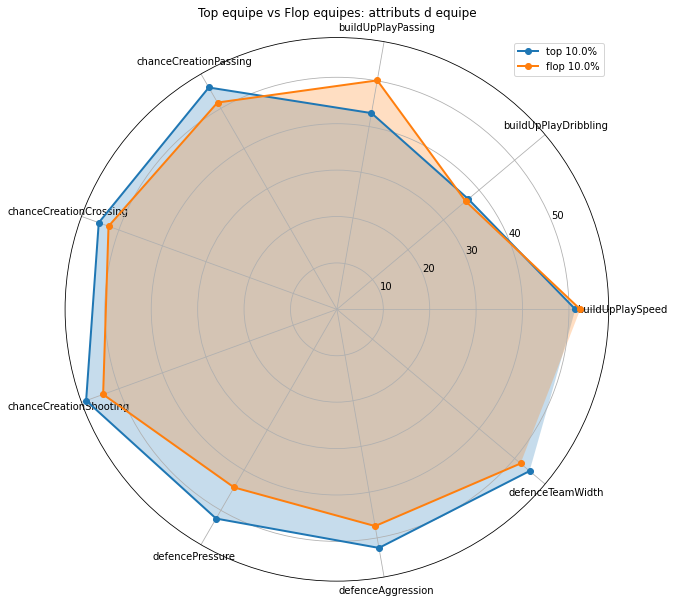

In [70]:
stats_top=df_top_teams_mean.values
stats_flop=df_flop_teams_mean.values

angles=np.linspace(0, 2*np.pi, len(attributs_equipes), endpoint=False)


fig=plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, stats_top, 'o-', linewidth=2, label='top '+ str(100-percent*100)+'%')
ax.fill(angles, stats_top, alpha=0.25)
ax.plot(angles, stats_flop, 'o-', linewidth=2, label='flop '+ str(100-percent*100)+'%')
ax.fill(angles, stats_flop, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels=attributs_equipes)
ax.set_title('Top equipe vs Flop equipes: attributs d equipe')
ax.grid(True)
ax.legend();

Les resultats sont ceux attendu. Ils sont similaires et même encore plus categoriques. Ceci permet de donner plus de credits aux analyses faites plus haut. 

## Conclusion: 

Il semble qu'un entraineur devrait privilegier une defense volontaire et engagé ainsi que des joueurs creatifs et habiles, capablent de donnes de long ballons ou se mettrent en situations de tirs. Ceci devrait se traduire par des joueurs jouant haut sur le terrain, empietant ainsi constamment sur le terrain adverse, pour que les defenseurs puissent être toujours au pressing et que les joueurs offensifs soient a la reception d'un ballon long. On espere pouvoir faire une analyse sur le positionnement des joueurs qui pourraient confirmer cette theorie. A contrario, il semble qu'il devrait faire passer au second plan le collectif, c'est a dire de jouer strategiquement en construction et en passe. 

# 3) Quels attributs de joueurs un entraineur devrait-il privilégier ?

On fait une analyse similaire, mais cette fois avec les joueurs qui composent les equipes.

C'est à dire, on prend les joueurs des meilleurs equipes et on compare au reste, et apres au plus mauvais.

## Ajoute Attributs joueurs 

In [71]:
#taille , poids, age des jouerus
df_player_att=pd.merge(df_player, players[['player_api_id', 'birthday', 'height', 'weight']], how='outer')
df_player_att['age']=df_player['season'].str.slice(0,4).astype(int)-pd.to_datetime(df_player_att['birthday']).dt.year

In [72]:
#On ajoute la saison dans la table attributs pour preparer au merge
players_att['date'] = pd.to_datetime(players_att['date'])
players_att['season'] = np.where(players_att['date'].dt.month>6, players_att['date'].dt.year.astype(str) + '/' + (players_att['date'].dt.year + 1).astype(str) , (players_att['date'].dt.year - 1).astype(str) + '/' + (players_att['date'].dt.year).astype(str))


In [73]:
#merge attributs et joeurus
df_player_att = pd.merge(df_player_att, players_att, how='left', on=[ 'player_api_id', 'season'])

df_player_att.head()

,player_api_id,team_api_id,season,position,poste,birthday,height,weight,age,id,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,2625.0,8569.0,2014/2015,"(4.0, 6.0)",milieu_defensif,1981-01-27 00:00:00,175.26,154,33.0,139844.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
1,2625.0,8569.0,2014/2015,"(4.0, 6.0)",milieu_defensif,1981-01-27 00:00:00,175.26,154,33.0,139845.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
2,2625.0,8569.0,2014/2015,"(4.0, 6.0)",milieu_defensif,1981-01-27 00:00:00,175.26,154,33.0,139846.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
3,2625.0,8569.0,2014/2015,"(6.0, 6.0)",milieu_defensif,1981-01-27 00:00:00,175.26,154,30.0,139844.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0
4,2625.0,8569.0,2014/2015,"(6.0, 6.0)",milieu_defensif,1981-01-27 00:00:00,175.26,154,30.0,139845.0,...,55.0,66.0,62.0,63.0,54.0,12.0,11.0,6.0,8.0,8.0


In [74]:
lst_players_att=[ 'height',
 'weight',
 'age', 'overall_rating',
 'potential',
 'preferred_foot',
 'attacking_work_rate',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'volleys',
 'dribbling',
 'curve',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'agility',
 'reactions',
 'balance',
 'shot_power',
 'jumping',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'vision',
 'penalties',
 'marking',
 'standing_tackle',
 'sliding_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes']

## Visualisations

### A) En general

In [75]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste=None)

#### Joueurs top equipes vs le reste

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


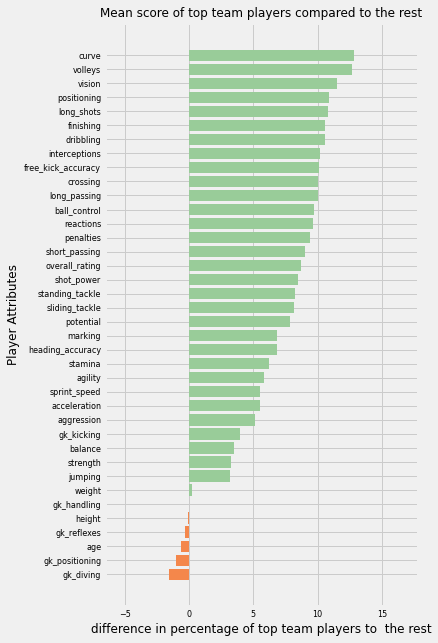

In [76]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

##### Interpretation

- On voit quel la plupart des attributs "capacité a creer des occasions" qui semblaient être corréles avec les equipes performantes(voir question 1) sont représentés ici (longshots, volley, finishing, vision, crossing, curve, longpassing...). Ce qui est cohérent avec les resultats obtenus precedemment.
- Il est interessant d'observer que les attributs defensifs (tackles, marking, aggression) sont ici pas ceux qui sortent les premiers (contrairement a la question precedente). Ceci laisse a penser qu'une fois qu'un certain niveau de défense est atteint, la capacité a creer des opportunites de buts est ce qui fait la difference entre les tres grandes equipes et le reste.
- Les attributs du goal semblent etre negativement correles avec la victoire ! (sauf la capacite a degager le ballon, ce qui est coherent avec ce qui est dit precedemment). L'age egalement, ce qui est logique, puisque les top equipes sont en general formes de joueurs confirmes, qui ont fait leur preuve autrefois dans d'autres clubs plus "formateurs".


#### Joueurs top equipes vs flop equipes

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


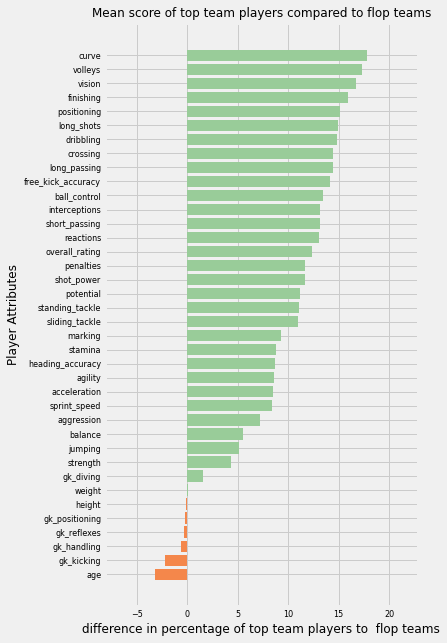

In [77]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

On voit des resultats similaires, sublimés.

### B) Par Poste

### a) Goalkeeper

In [78]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='goal')

##### Joueurs top equipes vs le reste

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


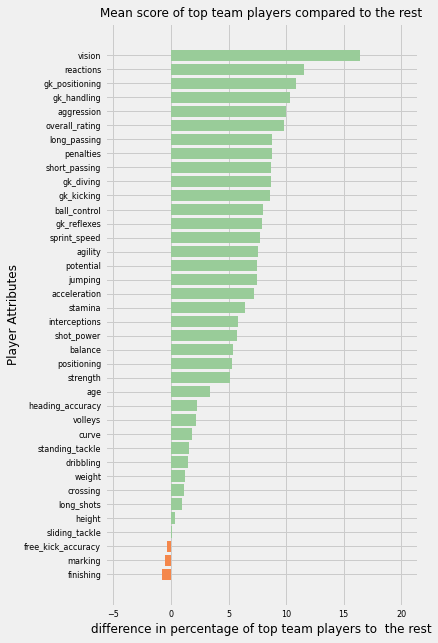

In [79]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

Les resultats sont assez attendus. Interessant que "vision" soit plus haut que les autres attributs, qui est un attribut offensif

##### Joueurs top equipes vs flop equipes

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


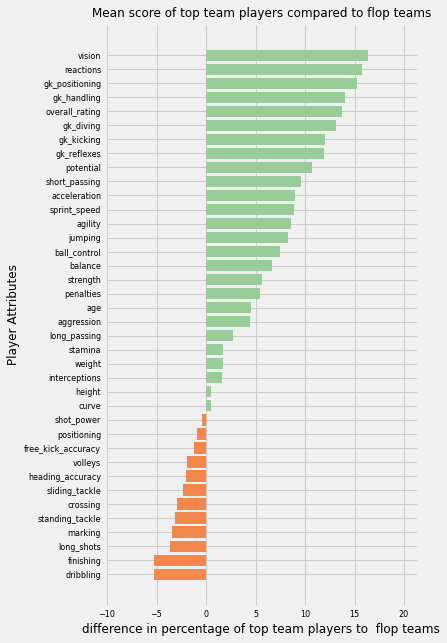

In [80]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

### b) Les lateraux

#### Defenseur lateral gauche

In [81]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='lateral_gauche')

##### Joueurs top equipes vs le reste

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


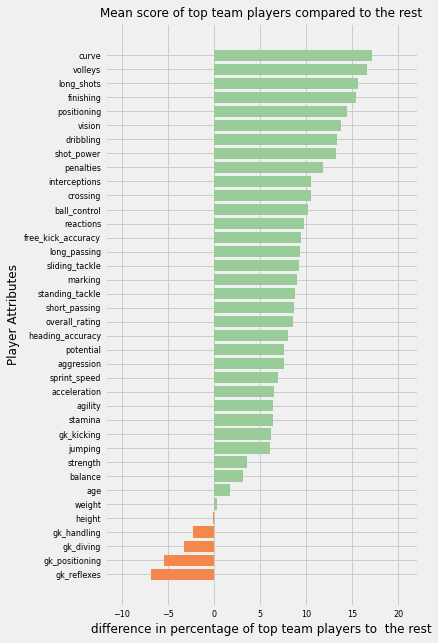

In [82]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

tres etonnant, les caracteristiques defensifs sont en retrait. 

##### Joueurs top equipes vs flop equipes


<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


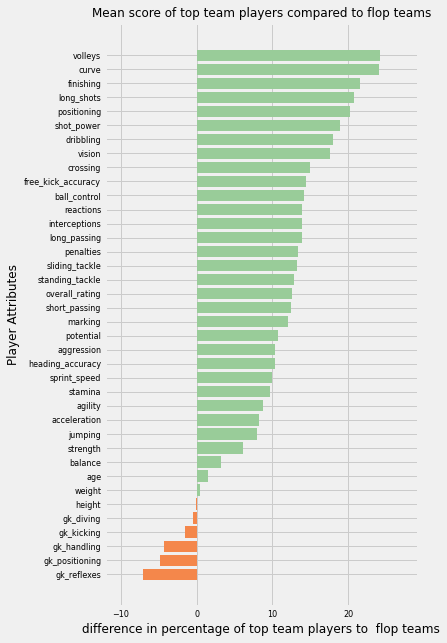

In [83]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

#### Defenseur lateral droit


In [84]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='lateral_droit')

##### Joueurs top equipes vs le reste

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


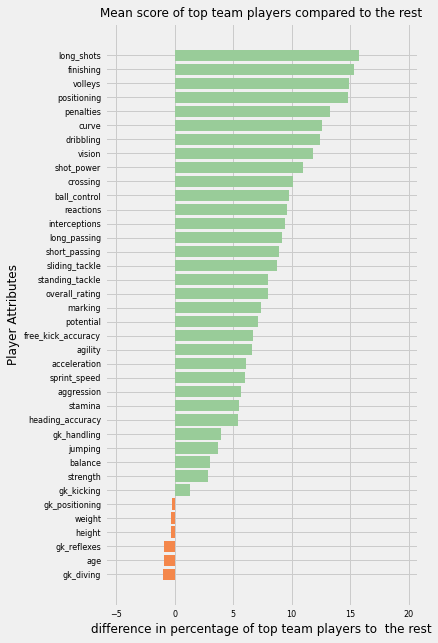

In [85]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

##### Joueurs top equipes vs flop equipes


<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


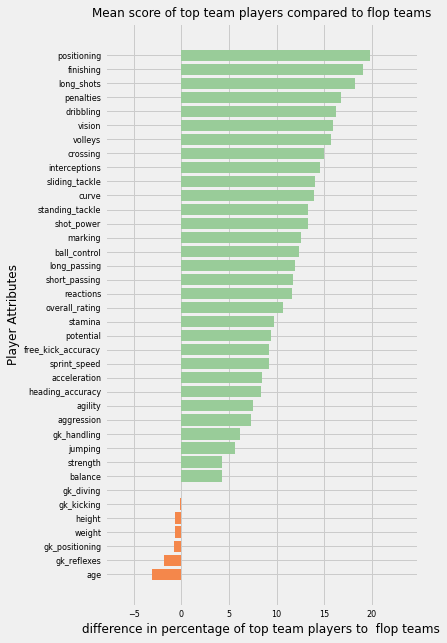

In [86]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

#### conclusion lateraux:

- a gauche ou a droite, les top attributs sont similaires. ce qui donne du credit a la coherence de l'analyse.
- il semble que els attributs offensifs sont plus mis en avant, et que la pluvalue des top equipes seraient donc d'avoir des lateraux capable d'attaquer, de centrer, et de marquer. Le positionement semble aussi important, puisqu'ils oscillent entre l'attaque et la defense.

### c) Defenseur centraux

In [87]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='defenseur_central')

##### Joueurs top equipes vs le reste

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


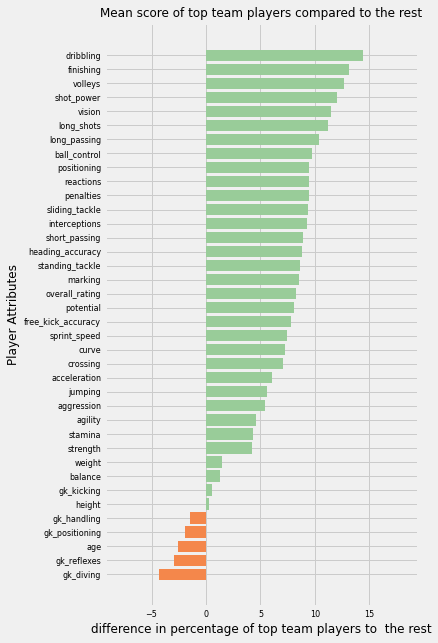

In [88]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

##### Joueurs top equipes vs flop equipes


<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


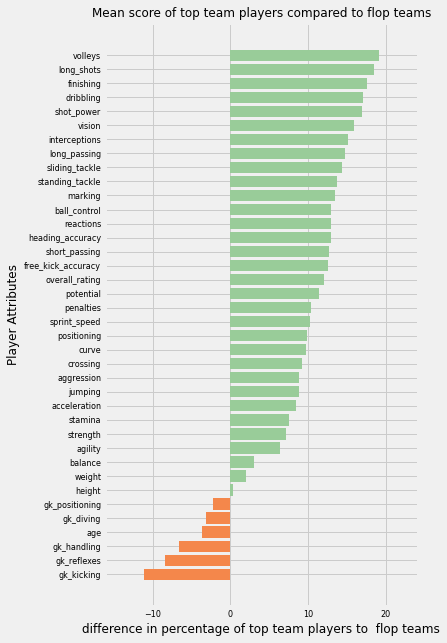

In [89]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

on peut tirer des conclusions similaires que pour les latéraux, surtout que les defenseurs centraux sont normalement moins offensifs

Pour les défenseurs centraux, qui partagent beaucoup de similarités avec les défenseurs centraux, ont eux plus le jeu de tête. Ce qui fait sens: les defenseurs centraux sont generalement ceux qui montent dans la surface de reparation lors de coup de pieds arrêtés.

### d) milieu lateraux

#### milieu gauche

In [90]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='milieu_gauche')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


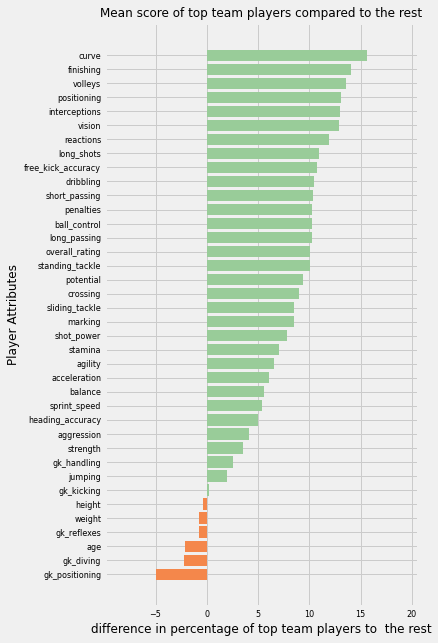

In [91]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


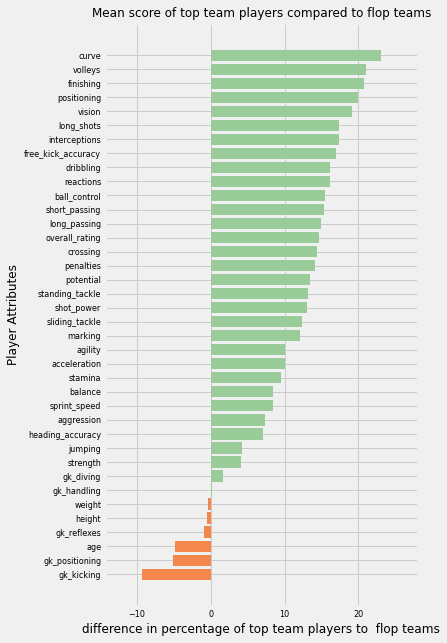

In [92]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

####  milieu droit

In [93]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='milieu_droit')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


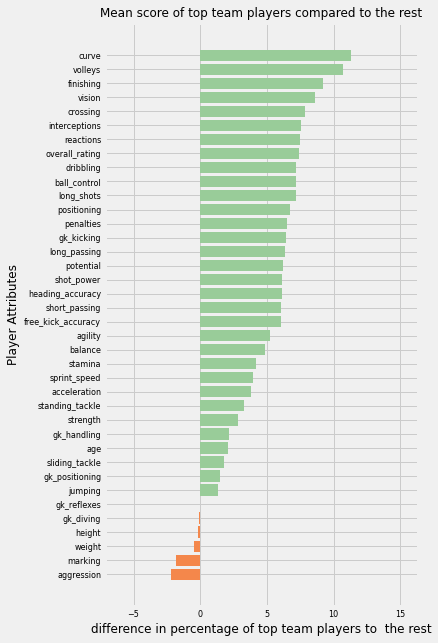

In [94]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


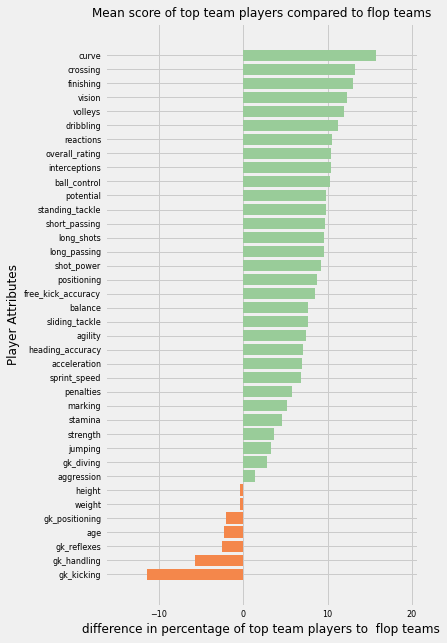

In [95]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

#### conclusion milieu gauche/droit:

On observe des caracteristiques similaires aux lateraux. ce qui est coherents. Il semblent que des milieux gauches des tops equipes soient capable de se projeter vers l'avant. De plus positioning et interception semblent important ce qui est logique.

### e) milieu defensif

In [96]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='milieu_defensif')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


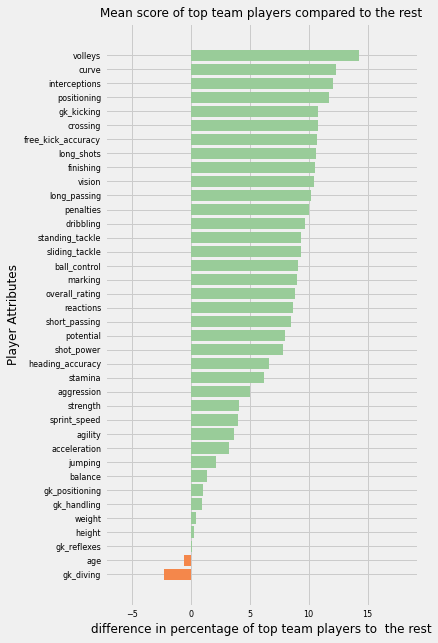

In [97]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

Les milieux defensifs des top equipes ont des attributs offensifs plus hauts. Jusqu'a maintenant, on constate que ce processus est generalises pour postes a tendance "defensifs"

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


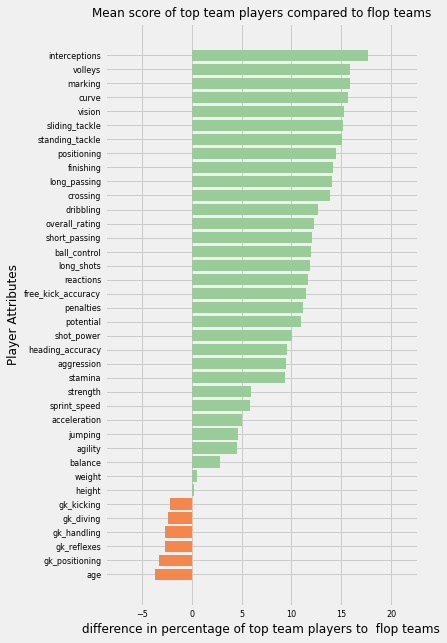

In [98]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

Interception est important pour les milieux defensifs

### f) milieu offensif

In [99]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='milieu_offensif')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


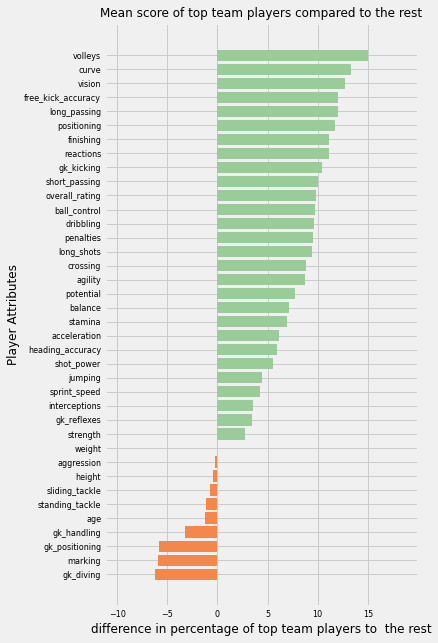

In [100]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


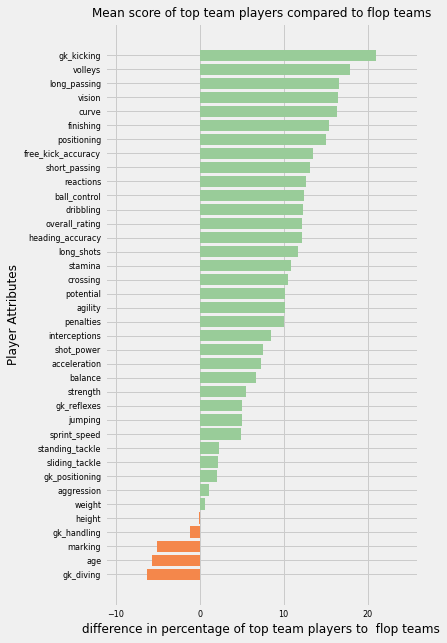

In [101]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

Ce qui est specifique aux milieu offesnsifs, c'est la capacité de tirer des coup francs. C'est vrai que ce sont souvent les joueurs a ces postes de techniciens qui sont chargés de tirer les coup francs

### g) ailier

##### ailier droit

In [102]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='ailier_droit')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


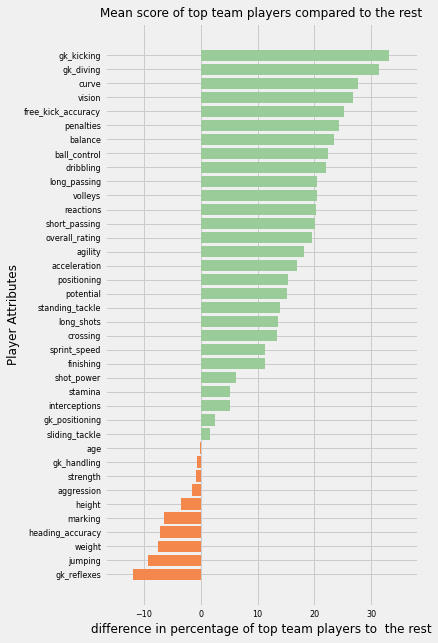

In [103]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


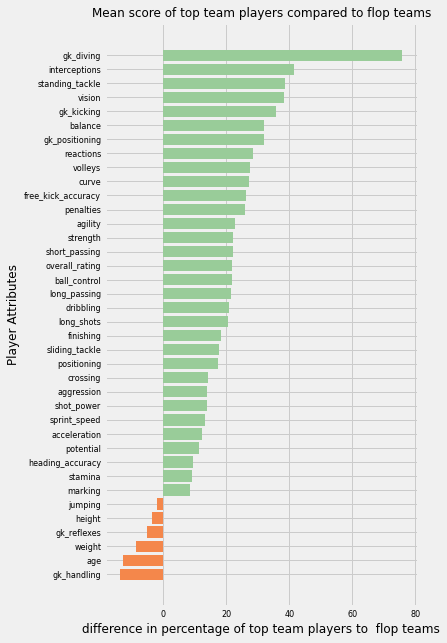

In [104]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

##### ailier gauche

In [105]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='ailier_gauche')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


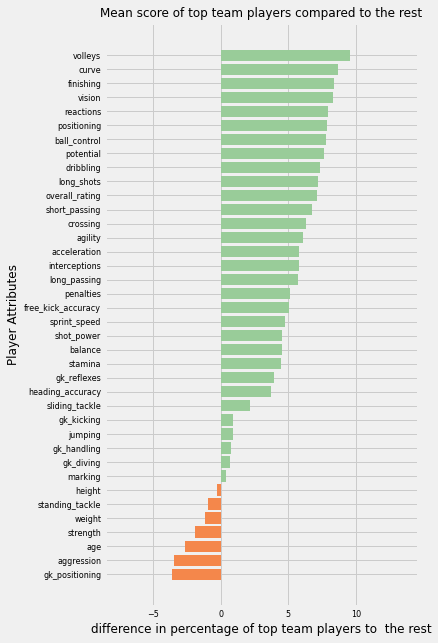

In [106]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


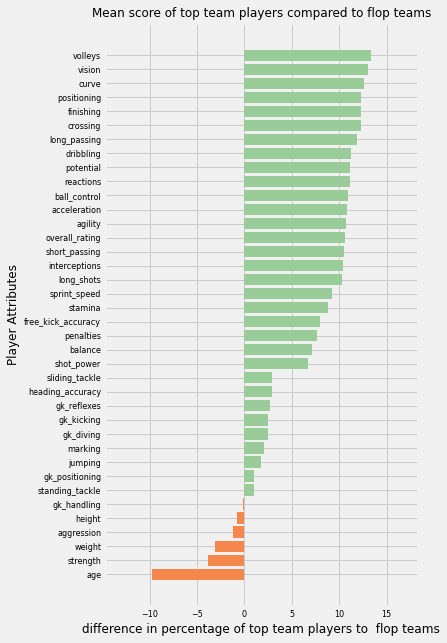

In [107]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

### h) attaquant

In [108]:
df_players_top_vs_autres, df_players_top_vs_flop=mean_players_top_autres_flop(df_player_att, poste='attaquant')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


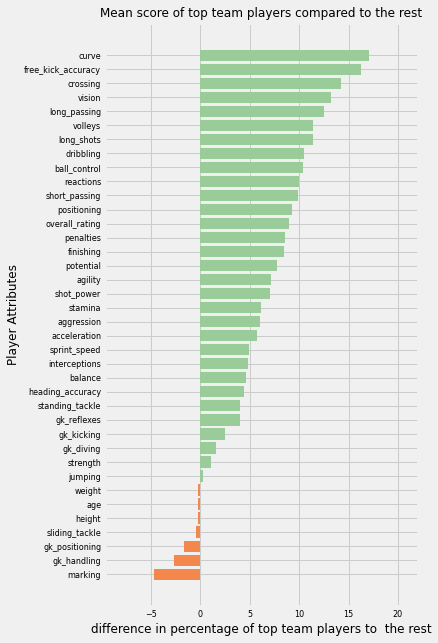

In [109]:
visualisation_players_att(df_players_top_vs_autres, title=' the rest')

<ipython-input-6-c7fdba3394a1>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=df_playersattr_compared['index'])


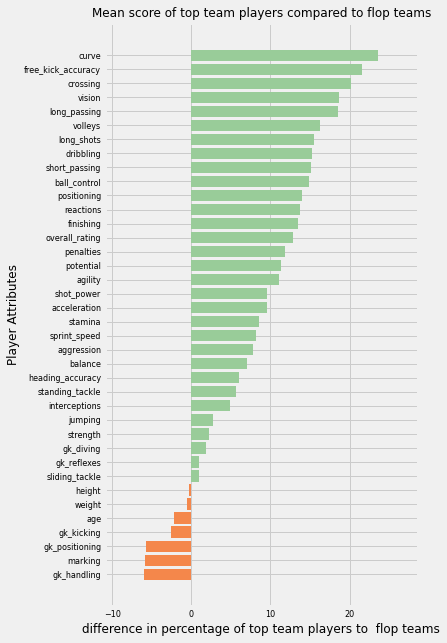

In [110]:
visualisation_players_att(df_players_top_vs_flop, title=' flop teams')

Conclusion:

- Les attributs offensifs sont mis en avant
- C'est souvent les mêmes attributs qui reviennent, qu'ils soient defensifs ou offensifs

# 4) Quelle formation d'équipe un entraineur devrait-il privilégier ?

Nous allons maintenant faire une analyse similaire avec les formations. Il est connu dans le football que les equipes adoptent differentes stratégie de formation à domicile et à l'extérieur. On va donc s'intéresser aux deux.

In [111]:
#on enleve les NaN, car les formations ne peuvent pas etre extraite
df_match_position.dropna(inplace=True)

In [112]:
#tranformer un tuple pour manipulation
df_match_position['home_formation']=df_match_position['home_formation'].apply(lambda x: tuple(x))
df_match_position['away_formation']=df_match_position['away_formation'].apply(lambda x: tuple(x))

Pour chaque saison, pour chaque equipe, on retient la formation la plus utilisée.

In [113]:

df_home_formation=df_match_position.groupby(['home_team_api_id', 'season'])['home_formation'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()


In [114]:
df_away_formation=df_match_position.groupby(['away_team_api_id', 'season'])['away_formation'].agg(lambda x: pd.Series.mode(x)[0]).to_frame().reset_index()


In [115]:
#rename colones
df_home_formation.columns=['team_api_id','season','home_formation']
df_away_formation.columns=['team_api_id','season', 'away_formation']

In [116]:
df_formation=df_home_formation.merge( df_away_formation, on=['team_api_id', 'season'])

In [117]:
df_formation

,team_api_id,season,home_formation,away_formation
0,1601,2013/2014,"(4, 2, 3, 1)","(4, 2, 3, 1)"
1,1601,2014/2015,"(4, 2, 3, 1)","(4, 2, 3, 1)"
2,1601,2015/2016,"(4, 2, 3, 1)","(4, 2, 3, 1)"
3,1773,2011/2012,"(3, 4, 3)","(4, 3, 3)"
4,1773,2012/2013,"(4, 1, 4, 1)","(4, 4, 2)"
...,...,...,...,...
1396,177361,2015/2016,"(4, 2, 3, 1)","(4, 2, 3, 1)"
1397,188163,2015/2016,"(4, 3, 3)","(4, 3, 3)"
1398,208931,2015/2016,"(4, 4, 1, 1)","(4, 4, 1, 1)"
1399,274581,2014/2015,"(4, 2, 3, 1)","(4, 2, 3, 1)"


Comme précédemment, on merge ce dataframe avec les trois dataframes utilisées pour les comparaisons, df_top_teams, df_autre_teams et df_flop_teams

In [118]:
df_top_teams=df_top_teams.merge(df_formation, on=['team_api_id', 'season'])
df_autre_teams=df_autre_teams.merge(df_formation, on=['team_api_id', 'season'])
df_flop_teams=df_flop_teams.merge(df_formation, on=['team_api_id', 'season'])

Pour chacun de ces dataframes, on calcule la frequence d'apparition des formations pour toutes equipes et saisons confondues.

In [119]:
df_top_teams['home_top_formation_frequency']= df_top_teams.groupby(['home_formation'])['season'].transform('count')
df_top_teams['home_top_formation_frequency']=df_top_teams['home_top_formation_frequency']/len(df_top_teams['home_top_formation_frequency'])*100

df_top_teams['away_top_formation_frequency']= df_top_teams.groupby(['away_formation'])['season'].transform('count')
df_top_teams['away_top_formation_frequency']=df_top_teams['away_top_formation_frequency']/len(df_top_teams['away_top_formation_frequency'])*100


In [120]:
df_autre_teams['home_autre_formation_frequency']= df_autre_teams.groupby(['home_formation'])['season'].transform('count')
df_autre_teams['home_autre_formation_frequency']=df_autre_teams['home_autre_formation_frequency']/len(df_autre_teams['home_autre_formation_frequency'])*100

df_autre_teams['away_autre_formation_frequency']= df_autre_teams.groupby(['away_formation'])['season'].transform('count')
df_autre_teams['away_autre_formation_frequency']=df_autre_teams['away_autre_formation_frequency']/len(df_autre_teams['away_autre_formation_frequency'])*100


In [121]:
df_flop_teams['home_flop_formation_frequency']= df_flop_teams.groupby(['home_formation'])['season'].transform('count')
df_flop_teams['home_flop_formation_frequency']=df_flop_teams['home_flop_formation_frequency']/len(df_flop_teams['home_flop_formation_frequency'])*100


df_flop_teams['away_flop_formation_frequency']= df_flop_teams.groupby(['away_formation'])['season'].transform('count')
df_flop_teams['away_flop_formation_frequency']=df_flop_teams['away_flop_formation_frequency']/len(df_flop_teams['away_flop_formation_frequency'])*100


Pour préparer au plot, on se débarasse des duplicats, et on merge les trois dataframes

In [122]:
home_top_formation=df_top_teams[['home_formation','home_top_formation_frequency']].drop_duplicates(subset="home_formation", keep='first').reset_index(drop=True)
home_autre_formation=df_autre_teams[['home_formation','home_autre_formation_frequency']].drop_duplicates(subset="home_formation", keep='first').reset_index(drop=True)
home_flop_formation=df_flop_teams[['home_formation','home_flop_formation_frequency']].drop_duplicates(subset="home_formation", keep='first').reset_index(drop=True)

In [123]:
home_formation=home_top_formation.merge(home_autre_formation, on='home_formation')
home_formation=home_formation.merge(home_flop_formation, on='home_formation')

In [124]:
away_top_formation=df_top_teams[['away_formation','away_top_formation_frequency']].drop_duplicates(subset="away_formation", keep='first').reset_index(drop=True)
away_autre_formation=df_autre_teams[['away_formation','away_autre_formation_frequency']].drop_duplicates(subset="away_formation", keep='first').reset_index(drop=True)
away_flop_formation=df_flop_teams[['away_formation','away_flop_formation_frequency']].drop_duplicates(subset="away_formation", keep='first').reset_index(drop=True)

In [125]:
away_formation=away_top_formation.merge(away_autre_formation, on='away_formation')
away_formation=away_formation.merge(away_flop_formation, on='away_formation')

In [126]:
home_formation

,home_formation,home_top_formation_frequency,home_autre_formation_frequency,home_flop_formation_frequency
0,"(4, 3, 3)",33.653846,17.086528,16.190476
1,"(3, 5, 2)",4.807692,2.738226,4.761905
2,"(4, 1, 4, 1)",2.884615,2.300110,1.904762
3,"(4, 2, 3, 1)",23.076923,33.406353,20.000000
4,"(4, 4, 2)",25.000000,27.053669,40.952381
5,"(4, 1, 3, 2)",2.884615,0.766703,0.952381
6,"(4, 3, 1, 2)",3.846154,2.628697,2.857143
7,"(4, 4, 1, 1)",0.961538,3.504929,3.809524
8,"(3, 4, 3)",0.961538,1.204819,0.952381
9,"(4, 1, 2, 1, 2)",0.961538,2.081051,0.952381


On peut alors faire un barplot pour comparer la corrélation des diverses formations avec la performance des équipes:

## A domicile

<AxesSubplot:xlabel='home_formation'>

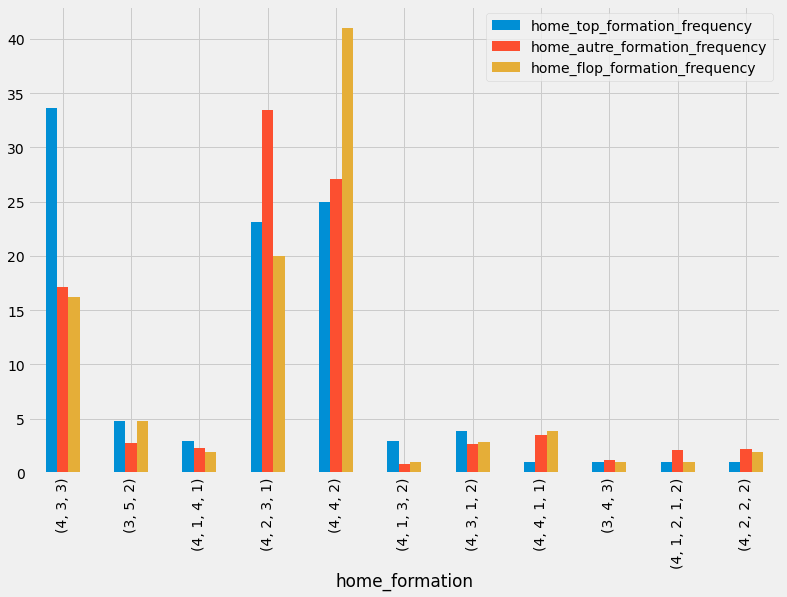

In [127]:
home_formation.plot(x="home_formation", y=["home_top_formation_frequency", "home_autre_formation_frequency", "home_flop_formation_frequency"], kind="bar", figsize=(12,8))

### Interpretation

D'après nos connaissances du football (et les données), on sait que les formations les plus utilisées sont (4,3,3) , (4,2,3,1) et surtout (4,4,2). Notre comparaison s'effectuera entre les 3. 

C’est intéressant de voir que la formation (4,3,3) est bien plus corrélée avec la performance que le (4,4,2). Le (4,3,3) est une formation offensive, rendue populaire par la grande AJAX d’amsterdam. A l’inverse, le (4,4,2) qui est souvent vu comme une solution plus sûre par les entraîneurs est plus représenté dans les équipes moins performantes, surtout dans les plus mauvaises.


### A l'exterieur

<AxesSubplot:xlabel='away_formation'>

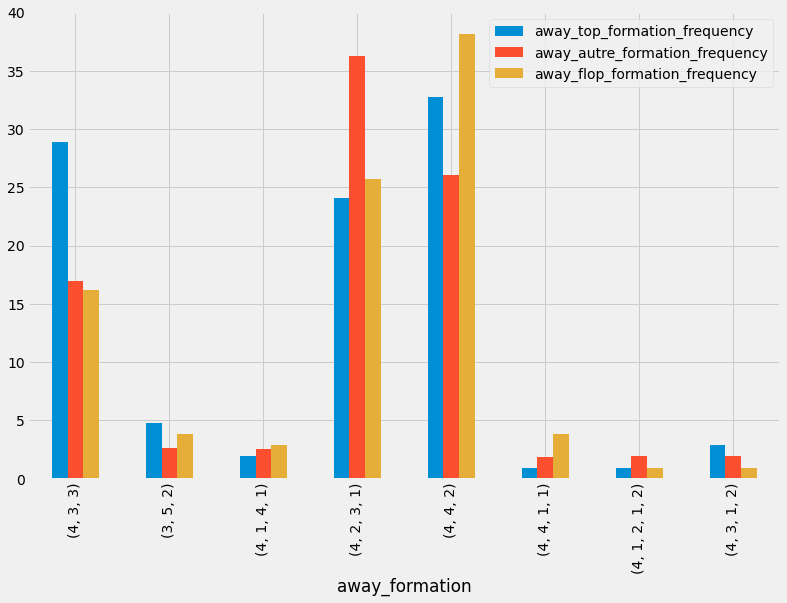

In [128]:
away_formation.plot(x="away_formation", y=["away_top_formation_frequency", "away_autre_formation_frequency", "away_flop_formation_frequency"], kind="bar", figsize=(12,8))

La tendance se confirme, même si à l’extérieur, le (4,4,2) est plus représenté dans les top équipes. Comme dit plutôt, il s’agit d’une composition plus “safe”, adaptée aux déplacements difficiles à l’extérieur. 

# 5) Conclusion

Dans ce notebook, on aura vu:

- L’établissement d’une métrique pour pouvoir jauger la performance des équipes, et ainsi donner une marche à suivre aux entraîneurs dans leurs choix. Cette métrique est basée sur le nombre de points moyen par match gagné par équipe, qui nous permettra de les classer en 3 catégories de niveau afin d’en comparer leurs attributs. On peut se demander si la métrique ne devrait pas être raffinée, pour une comparaison plus juste.
- La comparaison des attributs entre les teams de différents niveaux. Il ressort de cette analyse, que globalement le secteur défensif devrait être privilégié, avec des défenseurs qui jouent hauts, et des ballons longs distribués aux attaquants, contredisant alors une stratégie basée sur le collectif.
- La comparaison des attributs entre les joueurs de différents niveaux, montre qu’à titre individuel, les caractéristiques offensifs sont souvent ce qui fait la différence entre les équipes performantes et le reste. Il est toutefois important d’observer que les caractéristiques défensives ( à contrario de la question précédente) sont moins représentées.
- La comparaison des formations est très informative, elle semble être en faveur d’un (4,3,3).
 

Si nous devions répondre à la question du notebook en bref:

**Un entraîneur devrait opter pour une équipe qui joue globalement haut avec une défense agressive et engagée, et qui est capable de délivrer des ballons de loin aux joueurs. Ces derniers devraient avoir de bonnes capacités offensives et surtout de se créer des occasions plus que le reste. Le 4,3,3 est une formation idéale pour ce type de jeu, puisqu’elle contient 3 attaquants à la réception des ballons.**
